In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import eyepy as ep
from eyepy.data import load
import imageio.v2 as imageio
import os

In [3]:

ev = load("drusen_patient")
drusen_map = ep.drusen(ev.layers["RPE"].data, ev.layers["BM"].data, ev.shape, minimum_height=2)
ev.add_pixel_annotation(drusen_map, name="drusen", radii=[0.75,1.5,2.25], n_sectors=[2, 4, 8], offsets=[0, 45, 0])

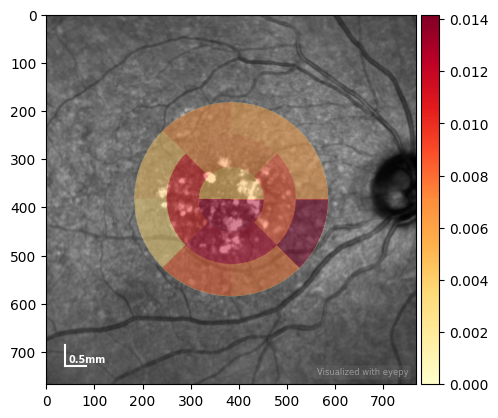

In [16]:
ev.plot(quantification="drusen",)

In [19]:
def plot(ev:ep.EyeVolume, bscan_index=None, bscan_region=np.s_[:,:], fundus_region=np.s_[:,:], figsize=(10, 5), layers=False, areas=False):
    if bscan_index is None:
        bscan_index = ev.shape[0]//2

    y_start = bscan_region[0].start if bscan_region[0].start is not None else 0
    y_stop = bscan_region[0].stop if bscan_region[0].stop is not None else ev[bscan_index].shape[0]

    x_start = bscan_region[1].start if bscan_region[1].start is not None else 0
    x_stop = bscan_region[1].stop if bscan_region[1].stop is not None else ev[bscan_index].shape[1]

    fig, axes = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [ev.localizer.shape[0]/ev.localizer.shape[1], (x_stop-x_start)/(y_stop-y_start)]})
    ev.plot(axes[0], region=fundus_region, bscan_positions=[bscan_index], bscan_region=True, projections=areas, projection_kwargs={"drusen":{"cbar": False}}, watermark=False)
    ev[bscan_index].plot(axes[1], layers=layers, areas=areas, region=bscan_region, watermark=False)

    axes[1].yaxis.tick_right()
    axes[1].yaxis.set_label_position("right")
    
    axes[0].margins(x=0, y=0, tight=True)
    axes[1].margins(x=0, y=0, tight=True)
    plt.gcf().tight_layout()
    

general = {"bscan_region": np.s_[100:350,:]}
frames = []
for i in range(0, 61, 10):
    frames.append({"bscan_index": i})

frames.append({"bscan_index": 60, "layers":["BM", "RPE"]})
frames.append({"bscan_index": 60, "layers":["BM", "RPE"], "areas":["drusen"]})
frames.append({"bscan_index": 60, "layers":["BM", "RPE"], "areas":["drusen"], "fundus_region": np.s_[20:768-20, 20:768-20]})
frames.append({"bscan_index": 60, "layers":["BM", "RPE"], "areas":["drusen"], "fundus_region": np.s_[60:768-60, 60:768-60]})
frames.append({"bscan_index": 60, "layers":["BM", "RPE"], "areas":["drusen"], "fundus_region": np.s_[100:768-100, 100:768-100]})

filenames = []
for i, frame in enumerate(frames):
    plot(ev, **general, **frame)
    for ax in plt.gcf().axes:
        ax.axis('off')
    #plt.gcf().set_facecolor("black")
    plt.savefig(f"frame{i}.png", dpi=150, facecolor="black", edgecolor="black", bbox_inches="tight", pad_inches=0)
    plt.close()
    filenames.append(f"frame{i}.png")

#filenames = filenames #+ #10*[filenames[-1]]

In [23]:

with imageio.get_writer('header.gif', mode='I', duration=1) as writer:
    for filename in filenames[:-1]:
        image = imageio.imread(filename)
        writer.append_data(image)
    
    writer._duration = 10
    image = imageio.imread(filenames[-1])
    writer.append_data(image) 


        
# Remove the temporary file
for filename in set(filenames):
    os.remove(filename)


# This requires gifsicle to be installed
from pygifsicle import optimize
optimize("header.gif")